<a href="https://colab.research.google.com/github/AI-ClassWork/Tensorflow_Fundamentals/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer Learning is leveraging a working model's existing archtiecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on similar problems
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own then we can adapt those patterns to our own data.

In [ ]:
# Are we using a GPU?
!nvidia-smi

Wed Mar 16 09:47:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    73W / 149W |   7953MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [ ]:
# Get data (10% of 10 food classes from Food101)
import zipfile

#Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#Unzip the downloaded file
zip_ref=zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-03-16 09:47:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.3’

10_food_classes_10_ 100%[===================>] 160.74M  39.2MB/s    in 4.1s    

2022-03-16 09:47:13 (39.2 MB/s) - ‘10_food_classes_10_percent.zip.3’ saved [168546183/168546183]



In [ ]:
# How many images in each folder
import os

#Walk through 10 percent data directory and list number of files
for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.'")

There are 2 directories and 0 images in '10_food_classes_10_percent'.'
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.'
There are 0 directories and 250 images in '10_food_classes

## Creating data loader(preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches


In [ ]:
#Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent=train_datagen.flow_from_directory(train_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")

print("Testing Images:")
test_data=test_datagen.flow_from_directory(test_dir,
                                           target_size=IMAGE_SHAPE,
                                           batch_size=BATCH_SIZE,
                                           class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks(things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks
* Tracking ecperiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training(before it trains for too long and overfits) with the EarlyStopping callback

In [ ]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir=dir_name + "/" +experiment_name + "/" +datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard logfiles to {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used TnsorFlow to create our own models layer by layer by scratch

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub. We can access pretrained models on https://tfhub.dev/

Browsing the TensorFlowHub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

In [ ]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
#Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [ ]:
# Let's make a create model() function to create a model from a URL
def create_model(model_url,num_classes=10):
  """

  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
  model_url(str):A TensorFlow Hub feature extraction URL.
  num_classes(int): Number of output neurons in the outputlayer,
    should be equal to number of target classes,default 10.

  Returns:
  An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons
  """

  #Download the pretrained model and save it as a Keras layer
  feature_extractor_layer=hub.KerasLayer(model_url,
                                  trainable=False,
                                  name="feature_extraction_layer",
                                  input_shape=IMAGE_SHAPE+(3,)) #Freeze the already learned patterns

  #Create our own model
  model=tf.keras.Sequential([feature_extractor_layer,
                             layers.Dense(num_classes,activation="softmax",name="output_layer")
                             ])
  
  return model

  

### Creating and testing ResNet TensorFlow Hub feature Extraction model

In [ ]:
# Create Resnet model
resnet_model=create_model(resnet_url,
                          num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Let's fit our resnet model to our data(10 percent of 10 classes)
resnet_history=resnet_model.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                      experiment_name="resnetv250"
                                                                      )])

Saving TensorBoard logfiles to tensorflow_hub/resnetv250/20220316-094718
Epoch 1/5
24/24 [==============================] - 28s 997ms/step - loss: 1.9323 - accuracy: 0.3533 - val_loss: 1.2223 - val_accuracy: 0.6120
Epoch 2/5
24/24 [==============================] - 22s 927ms/step - loss: 0.8939 - accuracy: 0.7293 - val_loss: 0.8900 - val_accuracy: 0.7092
Epoch 3/5
24/24 [==============================] - 26s 1s/step - loss: 0.6265 - accuracy: 0.8187 - val_loss: 0.7658 - val_accuracy: 0.7520
Epoch 4/5
24/24 [==============================] - 21s 918ms/step - loss: 0.4747 - accuracy: 0.8747 - val_loss: 0.7094 - val_accuracy: 0.7720
Epoch 5/5
24/24 [==============================] - 21s 917ms/step - loss: 0.3803 - accuracy: 0.9107 - val_loss: 0.6851 - val_accuracy: 0.7708


It did the thing!!! Our transfer learning feature extractor model out performed ALL of te previous models we built by hand..(substantially) and in a quicker training time AND with only 10 percent of the training examples.

In [ ]:
# let's create a function to plot our loss curves
# You could put a funtion like this into a script called "helper.py" and import it when you need it
import matplotlib.pyplot as plt

#Plot the validation and training curves
def plot_loss_curves(history):
  """

  Returns seperate loss curves for training and validation metrics.

  Args:
   history: TensorFlow history object

  Returns:
  Plots of training/validation loss curves
  """
  loss=history.history["loss"]
  val_loss=history.history["val_loss"]

  accuracy=history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]

  epochs=range(len(history.history["loss"]))

  #Plot loss 
  plt.plot(epochs,loss,label="training loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="training accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("Epochs")
  plt.legend()

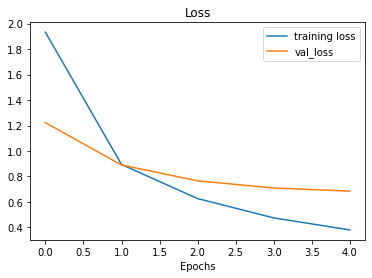

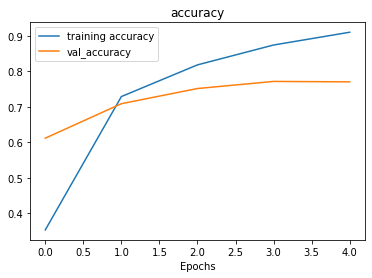

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub feature Extraction model

In [ ]:
# Create EfficientNetB0 feature extractor model
efficientnet_model=create_model(model_url=efficientnet_url,
                                num_classes=train_data_10_percent.num_classes)

#Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

#Fit EfficientNet model to 10% of training data
efficientnet_history=efficientnet_model.fit(train_data_10_percent,
                                            epochs=5,
                                            steps_per_epoch=len(train_data_10_percent),
                                            validation_data=test_data,
                                            validation_steps=len(test_data),
                                            callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                   experiment_name="efficientnetb0")])

Saving TensorBoard logfiles to tensorflow_hub/efficientnetb0/20220316-094951
Epoch 1/5
24/24 [==============================] - 31s 886ms/step - loss: 1.8343 - accuracy: 0.4387 - val_loss: 1.3051 - val_accuracy: 0.7128
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 1.0653 - accuracy: 0.7933 - val_loss: 0.8779 - val_accuracy: 0.8140
Epoch 3/5
24/24 [==============================] - 25s 1s/step - loss: 0.7611 - accuracy: 0.8413 - val_loss: 0.6984 - val_accuracy: 0.8392
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.6050 - accuracy: 0.8773 - val_loss: 0.6124 - val_accuracy: 0.8520
Epoch 5/5
24/24 [==============================] - 20s 842ms/step - loss: 0.5099 - accuracy: 0.8920 - val_loss: 0.5578 - val_accuracy: 0.8616


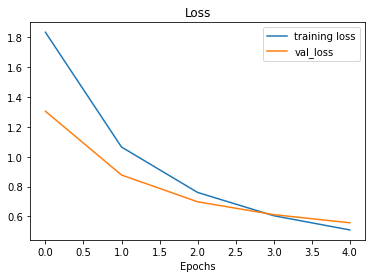

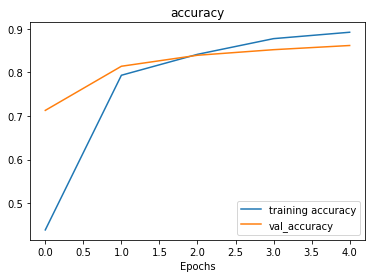

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


### Different types of transfer learning

* **"As is"** transfer learning - using an existing model with no changes whatsoever (e.g using ImageNet model on 1000  ImageNet classes, none of your own)

* **"Feature extraction"** transfer learning- use the prelearned patterns of an existing model (e.g EfficientNetB0 trained on ImageNet and adjust the output layer for your own problem (e.g 1000 classes->10 classes of food)

* **"Fine tuning"** transfer learning - Use the prelearned patterns of an existing model and fine tune many or all of the underlying layers(including new output layers)

In [ ]:
# How many layers does our efficientnetb0 feature extractor have?
efficientnet_model.layers[0]

## Comparing our models' results on TensorBoard

**Note:** When you upload things to TensorBoard.dev, your experiments are public. 

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs ResNet50v2" \
  --description "Comparing two different TF Hub feature extraction archtiectures using 10% of training data" \
  --one_shot



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/9kLOJwPDSaiq5MTOf67AlA/

[2022-03-16T09:52:05] Started scanning logdir.
[2022-03-16T09:52:16] Total uploaded: 150 scalars, 0 tensors, 5 binary objects (12.7 MB)
[2022-03-16T09:52:16] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/9kLOJwPDSaiq5MTOf67AlA/


Our Tensorboard experiments are uploaded publicly here: https://tensorboard.dev/experiment/J2T1P4tpSkGvy0t2qX8vgg/

In [ ]:
!tensorboard dev list

https://tensorboard.dev/experiment/9kLOJwPDSaiq5MTOf67AlA/
	Name                 EfficientNetB0 vs ResNet50v2
	Description          Comparing two different TF Hub feature extraction archtiectures using 10% of training data
	Id                   9kLOJwPDSaiq5MTOf67AlA
	Created              2022-03-16 09:52:05 (57 seconds ago)
	Updated              2022-03-16 09:52:15 (47 seconds ago)
	Runs                 10
	Tags                 5
	Scalars              150
	Tensor bytes         0
	Binary object bytes  13322723
https://tensorboard.dev/experiment/J2T1P4tpSkGvy0t2qX8vgg/
	Name                 EfficientNetB0 vs ResNet50v2
	Description          Comparing two different TF Hub feature extraction archtiectures using 10% of training data
	Id                   J2T1P4tpSkGvy0t2qX8vgg
	Created              2022-03-16 09:42:25 (10 minutes ago)
	Updated              2022-03-16 09:42:32 (10 minutes ago)
	Runs                 6
	Tags                 5
	Scalars              90
	Tensor bytes         0
	

In [ ]:
# Delete an experiment
#!tensorboard dev delete --experiment_id J2T1P4tpSkGvy0t2qX8vgg

Deleted experiment J2T1P4tpSkGvy0t2qX8vgg.
